In [ ]:
!pip install kaggle opencv-python tensorflow scikit-learn matplotlib pandas


In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashwinsingh07","key":"12d3d607d7cffadfcc73c5e8b31b9e0c"}'}

In [ ]:
!ls kaggle.json


kaggle.json


In [ ]:
import os

# Create the .kaggle directory and move kaggle.json there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0
 93% 369M/398M [00:00<00:00, 339MB/s]
100% 398M/398M [00:01<00:00, 398MB/s]


In [ ]:
!unzip -q face-mask-detection.zip -d data/

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET

# Set up directories
image_dir = '/content/data/images'
annot_dir = '/content/data/annotations'
output_dir = '/content/data/classified'

# Create class folders
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']
for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

# Process each XML file
for file in os.listdir(annot_dir):
    if not file.endswith(".xml"):
        continue

    tree = ET.parse(os.path.join(annot_dir, file))
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(image_dir, filename)

    image = cv2.imread(image_path)
    if image is None:
        continue

    for i, obj in enumerate(root.findall('object')):
        label = obj.find('name').text
        if label not in classes:
            continue

        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))

        face = image[ymin:ymax, xmin:xmax]
        if face.size == 0:
            continue

        save_path = os.path.join(output_dir, label, f"{filename[:-4]}_{i}.jpg")
        cv2.imwrite(save_path, face)

print("✅ Faces cropped and saved in /content/data/classified/")


✅ Faces cropped and saved in /content/data/classified/


In [ ]:
import os

base = "/content/data/classified"
for cls in os.listdir(base):
    print(cls, "→", len(os.listdir(os.path.join(base, cls))))


with_mask → 3232
without_mask → 717
mask_weared_incorrect → 123


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "/content/data/classified"
img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 3259 images belonging to 3 classes.
Found 813 images belonging to 3 classes.


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming train_gen.class_indices = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
labels = train_gen.classes  # This gives numeric labels for all training images

# Compute balanced weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dict format
class_weights = dict(enumerate(class_weights))
print("Computed class weights:", class_weights)


Computed class weights: {0: np.float64(10.973063973063972), 1: np.float64(0.420082495488528), 2: np.float64(1.8925667828106854)}


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8121 - loss: 0.5333 - val_accuracy: 0.9237 - val_loss: 0.2571
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9174 - loss: 0.2772 - val_accuracy: 0.9311 - val_loss: 0.2208
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9372 - loss: 0.1990 - val_accuracy: 0.9373 - val_loss: 0.2037
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9397 - loss: 0.1975 - val_accuracy: 0.9422 - val_loss: 0.2084
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9354 - loss: 0.2015 - val_accuracy: 0.9410 - val_loss: 0.2023
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9402 - loss: 0.1887 - val_accuracy: 0.9397 - val_loss: 0.2024
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9414 - loss: 0.1774 - val_accuracy: 0.9200 - val_loss: 0.2414
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9315 - loss: 0.1893 - val_accuracy: 0.939

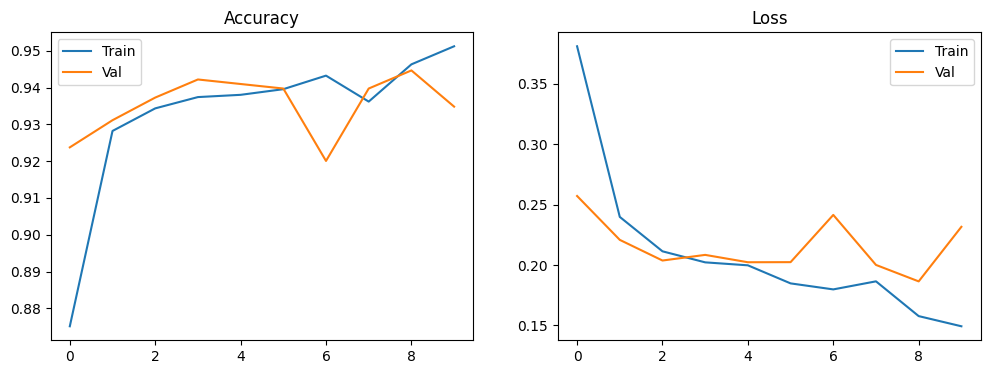

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.show()


In [ ]:
model.save("mask_classifier_cnn.h5")
print("✅ Model saved as mask_classifier_cnn.h5")


✅ Model saved as mask_classifier_cnn.h5


In [28]:
from google.colab import files
uploaded = files.upload()  # Upload a .jpg or .png file


Saving png5.png to png5 (6).png


In [ ]:
import os
print(os.listdir())
filename = list(uploaded.keys())[0]
print("Uploaded file:", filename)


['.config', 'png5 (1).png', 'png5.png', 'png5 (2).png', 'Screenshot 2025-03-04 203522.png', 'data', 'haarcascade_frontalface_default.xml', 'kaggle.json', 'face-mask-detection.zip', 'png5 (3).png', 'png5 (4).png', 'mask_classifier_cnn.h5', 'sample_data']
Uploaded file: png5 (4).png


In [ ]:
!pip install lz4 joblib --force-reinstall



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.1
    Uninstalling joblib-1.5.1:
      Successfully uninstalled joblib-1.5.1


In [ ]:
!pip install mtcnn


In [ ]:
import cv2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


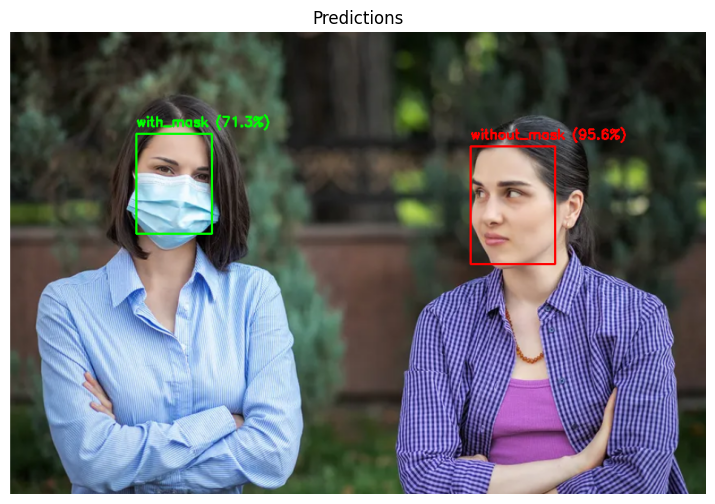

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from mtcnn.mtcnn import MTCNN  # Only if using MTCNN

# Load model
model = load_model("mask_classifier_cnn.h5")
class_names = ['mask_weared_incorrect', 'with_mask', 'without_mask']

# Read and prepare image
img_path = "png5.png"
image = cv2.imread(img_path)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces (HaarCascade or MTCNN)
detector = MTCNN()
faces = detector.detect_faces(rgb_image)

for result in faces:
    x, y, w, h = result['box']
    face = rgb_image[y:y+h, x:x+w]
    face_resized = cv2.resize(face, (128, 128))
    face_array = img_to_array(face_resized) / 255.0
    face_array = np.expand_dims(face_array, axis=0)

    pred = model.predict(face_array)
    class_id = np.argmax(pred)
    label = class_names[class_id]
    confidence = pred[0][class_id]

    color = (0, 255, 0) if label == 'with_mask' else (0, 0, 255) if label == 'without_mask' else (255, 0, 0)
    cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
    cv2.putText(image, f"{label} ({confidence:.1%})", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Show result
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Predictions")
plt.show()
